In [1]:
import requests
import urllib
import time
import os
#import time_standard as tst
from tqdm import tqdm
from urllib.parse import urlencode
from pyquery import PyQuery as pq


In [2]:
def user_info(uid):
    host = 'm.weibo.cn'
    base_url = 'https://%s/api/container/getIndex?' % host
    user_agent = 'User-Agent: Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13B143 Safari/601.1 wechatdevtools/0.7.0 MicroMessenger/6.3.9 Language/zh_CN webview/0'#这里的user_agent是网上找的
    user_id = str(uid)#这串数字就是用户id
    headers = {
    'Host': host,
    'Referer': 'https://m.weibo.cn/u/%s'%user_id,
    'User-Agent': user_agent
        
    }
    base_data = {}
    page = 5
    time_start=time.time()

In [3]:
def get_single_page(page,user_id):
    params = {
        'type': 'uid',
        'value': 1665372775,
        'containerid': int('107603' + user_id),#containerid就是微博用户id前面加上107603
        'page': page
    }
    host = 'm.weibo.cn'
    user_agent = 'User-Agent: Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13B143 Safari/601.1 wechatdevtools/0.7.0 MicroMessenger/6.3.9 Language/zh_CN webview/0'#这里的user_agent是网上找的

    base_url = 'https://%s/api/container/getIndex?' % host
    headers = {
    'Host': host,
    'Referer': 'https://m.weibo.cn/u/%s'%user_id,
    'User-Agent': user_agent
        
    }    

    url = base_url + urlencode(params)
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
    except requests.ConnectionError as e:
        print('抓取错误', e.args)


In [4]:
# 解析页面返回的json数据
def analysis_page(json,base_data):#保存图片的文件夹路径
    #base_data = {}
    items = json.get('data').get('cards')
    for item in items:
        item = item.get('mblog')
        if item:
            data = {
                #'created_at': item.get('created_at'),#微博创建日期
                'text': pq(item.get("text")).text(),  # 仅提取内容中的文本
                #'attitudes': item.get('attitudes_count'),#点赞数
                #'comments': item.get('comments_count'),#评论数
                #'reposts': item.get('reposts_count')#转发数
            }
            base_data[len(base_data)] = data#把得到的数据字典存入总字典
#             if pic_choice == 'y':#如果选择保存图片
#                 pics = item.get('pics')
#                 if pics:
#                     for pic in pics:
#                         picture_url = pic.get('large').get('url')#得到原图地址
#                         pid = pic.get('pid')#图片id
#                         pic_name = tst.timestr_standard(data['created_at']) + '_' + pid[25:]#构建保存图片文件名，timestr_standard是一个把微博的created_at字符串转换为‘XXXX-XX-XX’形式日期的一个函数
#                         download_pics(picture_url,pic_name,pic_filebagPath)#下载原图
    return base_data

In [5]:
def get_text(uid):
    user_id = str(uid)#这串数字就是用户id
    base_data = {}
    page = 5
    time_start=time.time()
    try:
        json = get_single_page(1,user_id)
        screen_name = json.get('data').get('cards')[0].get('mblog').get('user').get('screen_name')#博主昵称
        total = json.get('data').get('cardlistInfo').get('total')#博主微博总条数
    #         if pic_choice == 'y':#如果选择保存图片，则分配图片保存路径
    #             pic_filebagPath = 'D:\\python_project\\crawl\\weibo\\%s_picture'%screen_name
    #             os.makedirs(pic_filebagPath)#建立文件夹
    #         else:
    #             pic_filebagPath = None#选择不保存文件夹则不分配路径
    #         if page == 'all':#寻找总条数
    #             page = total//10
    #             while get_single_page(page).get('ok') == 1:
    #                 page = page + 1
    #             print('总页数为：%s'%page)
        page = int(page) + 1
        for page in tqdm(range(1,page)):  # 抓取数据
            json = get_single_page(page,user_id)
            base_data = analysis_page(json,base_data)
    except Exception as e:
        print('error:',e)
    finally:
            #base_dataPath = 'D:\\python_project\\crawl\\weibo\\base_data_%s.txt'%screen_name#base_data保存地址和文件名
            #f = open(base_dataPath,'w+',encoding='utf-8')
            #f.write(str(base_data))
            #f.close()
        time_end=time.time()
        print('\n totally cost',time_end-time_start)
        text = ''
        for i in base_data:
            text = text + base_data[i]['text']
        return text

In [62]:
text = get_text(5694106850)

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


 totally cost 3.29325270652771


In [6]:
def get_betterwords(cut_text):
    cut_text = cut_text.replace('的','')
    cut_text = cut_text.replace('了','')
    cut_text = cut_text.replace('转发','')
    cut_text = cut_text.replace('repost','')
    cut_text = cut_text.replace('我','')
    cut_text = cut_text.replace('在','')
    cut_text = cut_text.replace('是','')
    cut_text = cut_text.replace('你','')
    cut_text = cut_text.replace('佩姐','')
    cut_text = cut_text.replace('一个','')
    return cut_text

100%|██████████| 8/8 [00:02<00:00,  2.72it/s]



 totally cost 3.3417112827301025


(-0.5, 2999.5, 1999.5, -0.5)

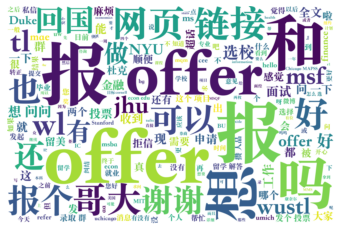

In [69]:
import jieba
from wordcloud import WordCloud
text = get_text(5933393467)
cut_text = " ".join(jieba.cut(text))
cut_text = get_betterwords(cut_text)
wordcloud = WordCloud(font_path="Songti.ttc",background_color = 'white',width=3000,height=2000).generate(cut_text)
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [7]:
import json
import jieba
filename = 'data1/2nd87.json'
data = open(filename, encoding='utf-8')
strJson1 = json.load(data)


In [8]:
list_id = []
for i in strJson1:
    fans = strJson1[i]['fans']
    list_id.append(str(i))
    for m in fans:
        list_id.append(m['id'])
len(list_id)

28421

In [9]:
set_listid = set(list_id)

In [10]:
len(set_listid)

19129

In [11]:
list_id = list(set_listid)

In [ ]:
dict_text = {}
for i in list_id:
    text = get_text(i)
    cut_text = " ".join(jieba.cut(text))
    cut_text = get_betterwords(cut_text)
    dict_text[i] = cut_text


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]
Building prefix dict from the default dictionary ...



 totally cost 3.8930139541625977


Dumping model to file cache /var/folders/nr/jzh22g_169d22drq1r9qbvth0000gn/T/jieba.cache
Loading model cost 1.435 seconds.
Prefix dict has been built successfully.


error: list index out of range

 totally cost 3.182378053665161


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]



 totally cost 2.039632797241211


100%|██████████| 5/5 [00:01<00:00,  3.55it/s]



 totally cost 1.927623987197876


100%|██████████| 5/5 [00:01<00:00,  3.73it/s]



 totally cost 1.8457269668579102


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]



 totally cost 2.508190870285034


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]



 totally cost 2.127358913421631


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]



 totally cost 2.5988259315490723


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]



 totally cost 2.4726901054382324


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



 totally cost 3.710744619369507


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



 totally cost 1.9260449409484863


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



 totally cost 2.595378875732422


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]



 totally cost 1.6584539413452148
error: list index out of range

 totally cost 0.24536490440368652


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]



 totally cost 2.317063808441162


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]



 totally cost 5.5755908489227295


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]



 totally cost 1.9502379894256592


100%|██████████| 5/5 [00:01<00:00,  2.91it/s]



 totally cost 2.0629420280456543


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]



 totally cost 2.165405035018921


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]



 totally cost 1.9522788524627686
error: list index out of range

 totally cost 0.3697788715362549
error: list index out of range

 totally cost 0.2548699378967285


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]



 totally cost 2.7198781967163086


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]



 totally cost 1.6046059131622314


100%|██████████| 5/5 [00:01<00:00,  2.85it/s]



 totally cost 2.1232690811157227


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]



 totally cost 2.8242809772491455


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]



 totally cost 1.9233269691467285


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 0.9744791984558105


100%|██████████| 5/5 [00:01<00:00,  4.26it/s]



 totally cost 1.4811270236968994


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]



 totally cost 2.5653390884399414


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]



 totally cost 1.5695319175720215


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]



 totally cost 2.3189640045166016


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]



 totally cost 2.760010004043579


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



 totally cost 3.107465982437134


100%|██████████| 5/5 [00:01<00:00,  2.99it/s]



 totally cost 2.376194953918457


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]



 totally cost 2.4576590061187744


100%|██████████| 5/5 [00:01<00:00,  2.88it/s]



 totally cost 2.454619884490967


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



 totally cost 2.313101053237915


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]



 totally cost 3.697844982147217


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]



 totally cost 2.384544849395752


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



 totally cost 2.190737009048462


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]



 totally cost 3.0850131511688232


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



 totally cost 2.310215950012207


 60%|██████    | 3/5 [00:01<00:01,  1.62it/s]